In [1]:
%load_ext autotime

time: 0 ns (started: 2021-09-06 22:36:02 -06:00)


Sentiment Analysis/Classification is an important NLP task as it allows businesses to learn about their customers' sentiments. Companies can save time and costs from manually labeling sentiments by training an NLP model for sentiment classification and then using the same model to predict sentiments for unseen texts.  

Our main goal is to identify an optimally performing classifier that classifies tweets into positive and negative. Objectively, we find answers for the below two questions:
- Which classifier among the classifiers - Naive Bayes, Logistic Regression, SVM, and XGBoost predicts sentiments better and why?
- Which words have more weights in positive and negative sentiments for a classifier to determine positive sentiments or negative sentiments?

In this notebook, we predict sentiments for tweets using the Naive Bayes classifier. 

First, let us prepare our dataset before converting it into features/inputs of the classification model. In the following few cells of this notebook, we will process our dataset by filtering out irrelevant information.

In [2]:
import pandas as pd
import numpy as np

# Load twitter dataset as a pandas dataframe
# dataset source - https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech
tweets_df = pd.read_csv("twitter.csv")
tweets_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


time: 813 ms (started: 2021-09-06 22:36:02 -06:00)


In [3]:
print("A tweet with positive sentiment:", tweets_df[tweets_df['label']==0].tweet.iloc[3])
print("A tweet with negative sentiment:", tweets_df[tweets_df['label']==1].tweet.iloc[5])

A tweet with positive sentiment: #model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  
A tweet with negative sentiment: @user lets fight against  #love #peace 
time: 0 ns (started: 2021-09-06 22:36:03 -06:00)


Column 'id' is not useful in our analysis. So, we will drop the column by using drop method of the dataframe.

In [4]:
tweets_df.drop(['id'], axis=1, inplace=True) #inplace=True drops 'id' column in the original dataframe

time: 0 ns (started: 2021-09-06 22:36:03 -06:00)


Let us see how many tweets have positive and negative sentiments.

<AxesSubplot:xlabel='label', ylabel='count'>

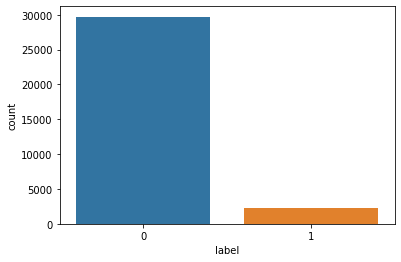

time: 1.19 s (started: 2021-09-06 22:36:03 -06:00)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='label', data=tweets_df)

In [6]:
tweets_df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

time: 0 ns (started: 2021-09-06 22:36:04 -06:00)


From the above count plot, we can see that we have 13 times more positive tweets (tweets with positive sentiments) than negative tweets (tweets with negative sentiments). We will need to balance the dataset because this imbalance in the dataset might influence our classifier to learn more from the features associated with positive tweets than with negative tweets, even when features should be equally important in classifying a tweet into positive or negative sentiment. For example, word "Texas, representing a state, should be equally important (or not important) in classifying a tweet into positive or negative sentiment. Besides, we might also see our classifier predicting positive sentiment for every tweet to get a high accuracy (low value of loss function) on the dev set without actually learning the mapping between features and classes. 

Let us now clean our dataset before we handle the imbalanced dataset.

In [7]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
import string
import nltk # Natural Language tool kit 
from nltk.corpus import stopwords
#print(string.punctuation)
#print(stopwords.words('english'))

# Create cleaned stopwords list by removing punctuations
stopwords_new = stopwords.words('english')+['user'] # add the word 'user' as a stopword since it has no value
stopwords_new = ''.join([ch for ch in ' '.join(stopwords_new) if ch not in string.punctuation]).split(' ')

# Create a function that filters punctuations and stop words from any text
def preprocess_text(text):
    filtered_text = ''.join([ch for ch in text if ch not in string.punctuation])
    preprocessed_text = ' '.join([word for word in filtered_text.split() if word.lower() not in stopwords_new])
    return preprocessed_text

time: 0 ns (started: 2021-09-06 22:36:05 -06:00)


In [9]:
# Use the above function on every row of our tweets_df
tweets_df['clean_tweet'] = tweets_df.tweet.map(lambda row: preprocess_text(row))
tweets_df.head(2)

,label,tweet,clean_tweet
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause offer wheelc...


time: 953 ms (started: 2021-09-06 22:36:05 -06:00)


Let us now split this dataset into training and validation/dev sets and then balance it. Why is this a better approach than balancing the dataset before splitting it? 

Splitting the dataset before balancing it ensures the validation dataset remains truly unseen. How so? By balancing the original dataset, we will duplicate the tweets of the minority class, negative tweets in our case, which will make these duplicated tweets appear in the training and validation set. Therefore, the classifier making predictions on the validation set might be seeing a few of these tweets in the training set. So, the classifier's performance on the validation set will not be an accurate estimate of the true performance of the classifier on unseen documents since the validation set is not truly unseen. 

So, we will first divide the dataset into training and validation sets and then handle the imbalanced training set. This way, our classifier will see an equal number of positive and negative labeled documents, ensuring that the classifier learns a mapping between features and classes. And, the validation set remains truly unseen.

Even before we split the original dataset into training and validation sets, we will transform each tweet into count-based feature vector. Sklearn provides classes for vectorizing text into numbers, such as the CountVectorizer or TFIDFVectorizer. 

First, we will instantiate CountVectorizer class. Since we have already cleaned our tweets, we do not need to create a pipeline for preprocessing and vectorizing tweets. If we want to create this pipeline, we could pass our preprocess_text function as a pipeline component. More specifically, we can assign the analyzer attribute of CountVectorizer class to the preprocess_text function:

```CountVectorizer(analyzer = preprocess_text)``` 

This pipeline will first clean tweets using our preprocess_text function, and then it will convert the cleaned tweets into vectors of numbers based on word counts. 

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
countvectorizer_obj = CountVectorizer(dtype = 'uint8') # dtype describes the datatype of each element of the Count matrix
# Unsigned integer of 8 bits can take any value between 0 and 255 (=2^8-1). Since number of characters in a tweet is 
# fixed at 140 (now 280 - https://help.twitter.com/en/using-twitter/how-to-tweet), we do not expect any tweet to 
# have a word that is repeated 255 times.
tweets_countvectorizer = countvectorizer_obj.fit_transform(tweets_df['clean_tweet'])
tweets_countvectorizer.shape

(31962, 43654)

time: 313 ms (started: 2021-09-06 22:36:06 -06:00)


In [11]:
X = pd.DataFrame(tweets_countvectorizer.toarray())
y = tweets_df['label']

time: 156 ms (started: 2021-09-06 22:36:06 -06:00)


We have converted tweets into count-based feature vectors where each tweet is now a 43,654-dimensional vector. Each of these dimensions is associated with a token out of 43,654 tokens of our vocabulary.

Let us now split 31,962 vectorized tweets into training and dev datasets using sklearn's train_test_split method such that our validation/dev set consists of 20 percent of 31,962 tweets. We also stratify such that we have similar ratios of positive and negative labels in training and dev datasets.

In [12]:
from sklearn.model_selection import train_test_split
train_X, dev_X, train_y, dev_y = train_test_split(X, y, test_size=0.2, stratify=tweets_df['label'])

time: 1.02 s (started: 2021-09-06 22:36:06 -06:00)


In [13]:
print('Training dataset')

print('Total number of tweets: ', len(train_y))
print('Number of positive tweets: ', sum(train_y==0))
print('Number of negative tweets: ', sum(train_y==1))


print('\nValidation dataset')

print('Total number of tweets: ', len(dev_y))
print('Number of positive tweets: ', sum(dev_y==0))
print('Number of negative tweets: ', sum(dev_y==1))

Training dataset
Total number of tweets:  25569
Number of positive tweets:  23775
Number of negative tweets:  1794

Validation dataset
Total number of tweets:  6393
Number of positive tweets:  5945
Number of negative tweets:  448
time: 16 ms (started: 2021-09-06 22:36:07 -06:00)


In [14]:
# Load imblearn python package for handling imbalanced dataset
# To install imblearn package, uncomment the below line of code
#!pip install imblearn
import imblearn
print(imblearn.__version__)

0.8.0
time: 219 ms (started: 2021-09-06 22:36:07 -06:00)


In [15]:
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority') #sampling_strategy lets you 
# define imbalanced data handling strategy
# For more details, see https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.RandomOverSampler.html
oversampled_train_X, oversampled_train_y = oversample.fit_resample(train_X, train_y)

time: 41 s (started: 2021-09-06 22:36:07 -06:00)


In [16]:
print('After balancing the training dataset')

print('Number of positive tweets: ', sum(oversampled_train_y==0))
print('Number of negative tweets: ', sum(oversampled_train_y==1))

After balancing the training dataset
Number of positive tweets:  23775
Number of negative tweets:  23775
time: 15 ms (started: 2021-09-06 22:36:48 -06:00)


In [17]:
oversampled_train_X.shape

(47550, 43654)

time: 0 ns (started: 2021-09-06 22:36:48 -06:00)


Now, we have balanced our training dataset by duplicating negative tweets, which represents our minority class. So finally, we have a balanced training dataset of 23,775 positive and negative tweets. Next, we will train our Naive Bayes classifier on this balanced dataset.

Naive Bayes classifier is a classification algorithm based on the Bayes theorem. It applies the Naive Bayes theorem on multinomially distributed data to classify data. It allows us to compute the probability of a class given sample data, and assumes the predictors/features are independent of each other. So, each predictor contributes to the probability of a class independently, which makes this classifier naive. If we do not consider this assumption, then we will have $k*(2^{vocab size}-1)$

Let us take an example of whether a gym will be open or closed. And let's say this depends on whether the gym has enough staff available and whether a given day is a holiday. Although the presence or absence of staff might depend on whether today is a holiday or not, the Naive Bayes considers them independent in the estimation of the probability of whether the gym will be open or not. It considers these features independent because the multinomial distribution of data assumes the independence of features.

Fitting a Naive Bayes classifier model on training data means estimating the likelihoods of a tweet in the training dataset for each class and then identifying the class with maximum posterior probability for the tweet. Later, we will explain this in more detail.

In [18]:
from sklearn.naive_bayes import MultinomialNB
# Instantiate multinomial naive bayes classifier
NB_classifier = MultinomialNB()
NB_classifier.fit(oversampled_train_X, oversampled_train_y)

MultinomialNB()

time: 2min 6s (started: 2021-09-06 22:36:48 -06:00)


In [19]:
# Number of samples associated with each class label
print(NB_classifier.class_count_)

[23775. 23775.]
time: 16 ms (started: 2021-09-06 22:38:55 -06:00)


In [20]:
# Each feature's occurence in a class is stored in NB_classifier.feature_count_
print(NB_classifier.feature_count_)

# with shape
print('Shape of classXfeature matrix:', NB_classifier.feature_count_.shape)

[[  1.   1.   0. ... 223.   1.   1.]
 [  0.   0.   0. ...   0.   0.  12.]]
Shape of classXfeature matrix: (2, 43654)
time: 16 ms (started: 2021-09-06 22:38:55 -06:00)


In [21]:
sum_pos = NB_classifier.feature_count_.sum(axis=1)[0]
sum_neg = NB_classifier.feature_count_.sum(axis=1)[1]

print('Count of all tokens in positive tweets = ', sum_pos)
print('Count of all tokens in negative tweets = ', sum_neg)

Count of all tokens in positive tweets =  184992.0
Count of all tokens in negative tweets =  194485.0
time: 0 ns (started: 2021-09-06 22:38:55 -06:00)


#### Procedure for classification

Identifying a class for an unseen tweet is computing posterior probabilities for each of the two classes given the tweet and identifying the maximum of two probabilities. We can calculate the posterior probability for a class, e.g., positive class, by multiplying the likelihood of the unseen tweet given a positive class with the prior probability of the positive class. Since the number of positive tweets is equal to the number of negative tweets in our training set, prior probabilities for both classes equal 0.5. 

Let us take an example of an unseen tweet as 'algebra is great' and demonstrate the computations involved below: 

$$posterior\;probability = \frac{likelihood * prior\;probability}{marginal\;probability}$$

$$p(class|tweet) = \frac{p(tweet|class) * p(class)}{p(tweet)}$$

Since occurrences of features are assumed to be independent of each other, we can compute likelihoods of observing a tweet ```algebra is great``` in positive and negative classes by calculating the product of likelihoods of observing individual words of a tweet in each of the two classes as well as the marginal probability of tweet (= probability of a single event of observing the tweet while ignoring tweet's dependence on any other event) in the following way.

$$
p(tweet|class=positive) = p(algebra|class=positive)*p(is|class=positive)*p(great|class=positive)
$$

$$
p(tweet|class=negative) = p(algebra|class=negative)*p(is|class=negative)*p(great|class=negative)
$$

$$
p(tweet) = p(algebra) * p(is) * p(great)
$$

In this notebook, we have assumed our data to be multinomially distributed. Maximum likelihood estimation of a multinomially distributed data results in a smoothed likelihood estimate of observing a token in a particular class:

$$
p(token|class=positive) = \frac{Count\;of\;token\;in\;positive\;tweets + \alpha}{Total\;count\;of\;all\;tokens\;in\;positive\;tweets + \alpha*number\;of\;tokens}
$$

Alpha is a smoothing coefficient to deal with tokens that have zero frequency in a class. 

If ```p(tweet|class=positive) > p(tweet|class=negative)```, then ```NB_classifier``` will assign tweet as positive otherwise negative since marginal probability of tweet, ```p(tweet)```, is same for both the classes.

Let us identify which tokens have high likelihoods within each class. We will evaluate log-likelihoods instead of just likelihoods since likelihood values are very small. For example, the highest likelihood value for a positive class associated with a token is 0.001. All other likelihood values will be smaller than this value. 

In [22]:
print('Maximum log likelihood value for positive class = ', max(NB_classifier.feature_log_prob_[0]))

print('Corresponding likelihood value for the above log likelihood = ', pow(10, max(NB_classifier.feature_log_prob_[0])))      

Maximum log likelihood value for positive class =  -4.68075886728068
Corresponding likelihood value for the above log likelihood =  2.0856485734239707e-05
time: 15 ms (started: 2021-09-06 22:38:55 -06:00)


Since Sklearn's feature_log_prob_ matrix is a token's index by log probability matrix, we will need to convert index into token. Sklearn's count vectorizer creates a token-to-index mapping for all tokens from our training data's vocabulary, which is stored in the 'vocabulary_' attribute of countvectorizer_obj. We will first create a dictionary for storing index as keys and tokens as values (reversing the token-to-index mapping to index-to-token mapping) and then use this dictionary to create a list of tuples of the form ```(token, log probability) ```.

In [24]:
# reverse token to index mapping and store this as a dictionary
key_vocab = {}

for word in countvectorizer_obj.vocabulary_:
    key_vocab[countvectorizer_obj.vocabulary_[word]] = word

time: 32 ms (started: 2021-09-06 22:38:55 -06:00)


In [25]:
pos_log_likelihoods = list(enumerate(NB_classifier.feature_log_prob_[0]))
pos_log_likelihoods.sort(key=lambda a: a[1], reverse=True)
pos_words_log_likelihoods = [(key_vocab[tup[0]], tup[1]) for tup in pos_log_likelihoods]

neg_log_likelihoods = list(enumerate(NB_classifier.feature_log_prob_[1]))
neg_log_likelihoods.sort(key=lambda a: a[1], reverse=True)
neg_words_log_likelihoods = [(key_vocab[tup[0]], tup[1]) for tup in neg_log_likelihoods]

time: 94 ms (started: 2021-09-06 22:38:55 -06:00)


In [26]:
pos_words_log_likelihoods[:10]

[('love', -4.68075886728068),
 ('day', -4.877715295178549),
 ('happy', -5.156059519884286),
 ('amp', -5.402616153723057),
 ('life', -5.534207681529753),
 ('im', -5.541989821971808),
 ('time', -5.557738178939947),
 ('today', -5.688358361357011),
 ('thankful', -5.707928457551108),
 ('positive', -5.722527256972261)]

time: 0 ns (started: 2021-09-06 22:38:55 -06:00)


In [27]:
neg_words_log_likelihoods[:10]

[('amp', -4.436472324671689),
 ('trump', -4.670404621353269),
 ('libtard', -4.986731525678046),
 ('like', -5.052172462890639),
 ('white', -5.091682121264545),
 ('black', -5.125725005708463),
 ('racist', -5.3506369040794155),
 ('politics', -5.409879737642276),
 ('people', -5.540063286497114),
 ('liberal', -5.5551497795304945)]

time: 0 ns (started: 2021-09-06 22:38:55 -06:00)


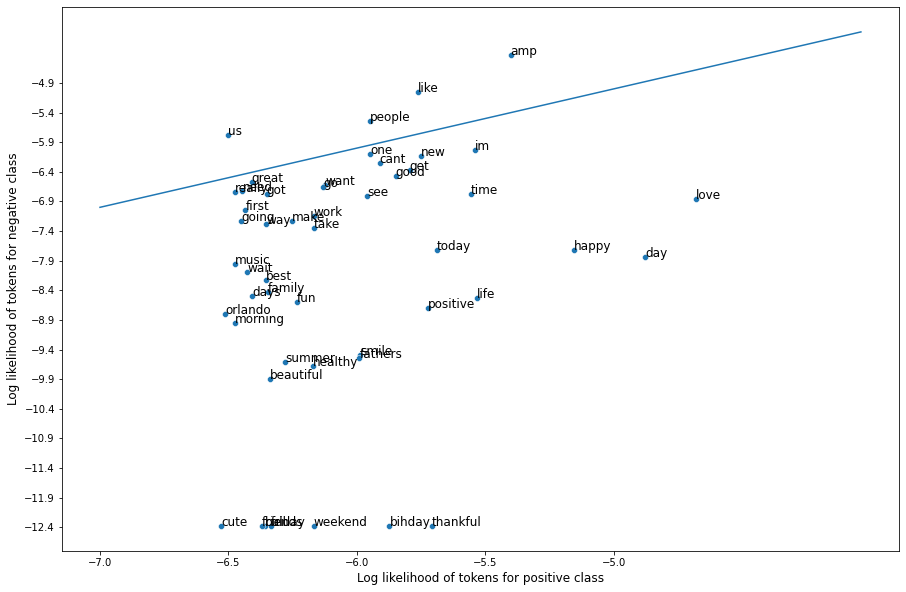

time: 547 ms (started: 2021-09-06 22:38:55 -06:00)


In [28]:
# Create a dataframe to store log_likelihoods for positive and negative classes for all tokens
class_logprob_df = pd.concat([pd.DataFrame(pos_words_log_likelihoods, columns=['token', 'pos']).set_index('token'), 
                              pd.DataFrame(neg_words_log_likelihoods, columns=['token', 'neg']).set_index('token')], 
                             axis=1, join='inner')

plt.figure(figsize=(15,10))

num_tokens = 50
ax = sns.scatterplot(data=class_logprob_df.iloc[:num_tokens], x='pos', y='neg')
ax.set_xlabel('Log likelihood of tokens for positive class', fontsize='large')
ax.set_ylabel('Log likelihood of tokens for negative class', fontsize='large')

def find_extremes(series, extreme_type='max', decimal_places=1):
    if extreme_type == 'max':
        return float(format(max(series), '.'+str(decimal_places)+'f'))
    elif extreme_type == 'min':
        return float(format(min(series), '.'+str(decimal_places)+'f'))
    
plt.xticks(np.arange(-7.0, 
                     find_extremes(class_logprob_df[:num_tokens].pos), 0.5))
plt.yticks(np.arange(find_extremes(class_logprob_df[:num_tokens].neg, 'min'), 
                     find_extremes(class_logprob_df[:num_tokens].neg), 0.5))
lims = [
    max(min(ax.get_xlim()), min(ax.get_ylim())),  
    max(max(ax.get_xlim()), max(ax.get_ylim()))
]

# now plot both limits against each other
ax.plot(lims, lims)

for i in range(num_tokens):
    plt.text(
        x=class_logprob_df.pos.iloc[i],
        y=class_logprob_df.neg.iloc[i],
        s=class_logprob_df.iloc[i].name,
        fontsize='large'
    )

In the above scatter plot, we see 50 tokens with the highest likelihood of being observed in a positive class. We use both likelihood values, one likelihood value of being observed in positive class and another of being observed in negative class.

The blue line represents tokens with equal likelihoods of being observed in both positive and negative classes. As we can see from the scatter plot, tokens like ```love``` have higher log-likelihood values for the positive class than for the negative class. Likewise, tokens like ```don't``` have higher log-likelihood values for negative class than for positive class.

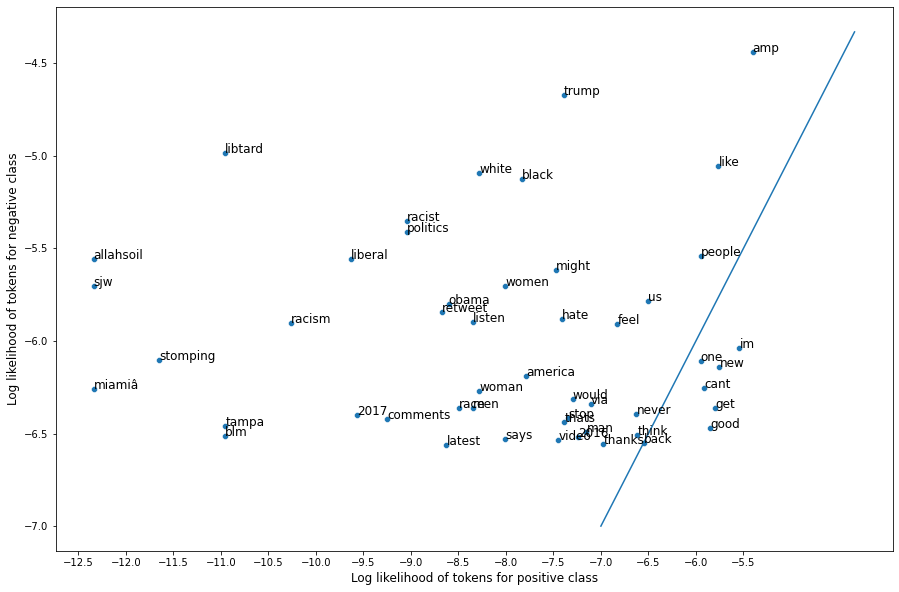

time: 344 ms (started: 2021-09-06 22:38:56 -06:00)


In [29]:
# Create a dataframe to store log_likelihoods for positive and negative classes for all tokens
class_logprob_df = pd.concat([pd.DataFrame(neg_words_log_likelihoods, columns=['token', 'neg']).set_index('token'), 
                              pd.DataFrame(pos_words_log_likelihoods, columns=['token', 'pos']).set_index('token')], 
                             axis=1, join='inner')

plt.figure(figsize=(15,10))

num_tokens = 50
ax = sns.scatterplot(data=class_logprob_df.iloc[:num_tokens], x='pos', y='neg')
ax.set_xlabel('Log likelihood of tokens for positive class', fontsize='large')
ax.set_ylabel('Log likelihood of tokens for negative class', fontsize='large')

def find_extremes(series, extreme_type='max', decimal_places=1):
    if extreme_type == 'max':
        return float(format(max(series), '.'+str(decimal_places)+'f'))
    elif extreme_type == 'min':
        return float(format(min(series), '.'+str(decimal_places)+'f'))
    
#find_extremes(class_logprob_df[:num_tokens].pos, 'min')    
plt.xticks(np.arange(-12.5, 
                     find_extremes(class_logprob_df[:num_tokens].pos), 0.5))
plt.yticks(np.arange(-7.0, 
                     find_extremes(class_logprob_df[:num_tokens].neg), 0.5))
lims = [
    max(min(ax.get_xlim()), min(ax.get_ylim())),  
    max(max(ax.get_xlim()), max(ax.get_ylim()))
]

# now plot both limits against eachother
ax.plot(lims, lims)

for i in range(num_tokens):
    plt.text(
        x=class_logprob_df.pos.iloc[i],
        y=class_logprob_df.neg.iloc[i],
        s=class_logprob_df.iloc[i].name,
        fontsize='large'
    )

In the above scatter plot, we see 50 tokens that are highly likely to be observed in the negative class. As we can see from the plot, tokens like racist and politics appear on the left-hand side of the blue line, which means that their log-likelihoods for the negative class are higher than for the positive class. One way to improve the Naive Bayes model is to filter noun tokens, such as tampa and america. 

We have seen two categories of tokens:

```
p(token_category1|positive) > p(token_category1|negative) 
p(token_category1|negative) > p(token_category1|positive) 
```

After visualizing a few of the tokens with high log-likelihoods, we can conclude that the Naive Bayes identified tokens that should appear more often in positive and negative tweets. One thing to note here is that Naive Bayes maximizes the log-likelihood of a token for the class in which the token appears more frequently. This maximization is useful for tokens that carry sentiment value. However, this will not be useful for tokens that do not carry sentiment value but are assigned a higher likelihood value based on the frequency of that token in a particular class. For example, tampa is a city. It might carry positive or negative perceptions among a few individuals but characterizing it as negative based on the number of times it is observed in negative tweets is a bad approach. First, it carries no sentiment value and should be labelled as neutral. Second, this will result in poor predictions on unseen tweets. Thus, although the Naive Bayes classifier has a good performance, its likelihood estimates should be considered helpful with a grain of salt.

Now let us see how our classifier is performing on unseen tweets.

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

time: 0 ns (started: 2021-09-06 22:38:56 -06:00)


<AxesSubplot:>

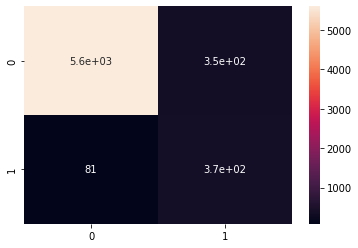

time: 1.33 s (started: 2021-09-06 22:38:56 -06:00)


In [31]:
# Predicting the Test set results
predict_dev_y = NB_classifier.predict(dev_X)
cm = confusion_matrix(dev_y, predict_dev_y)
sns.heatmap(cm, annot=True)

In [32]:
print(classification_report(dev_y, predict_dev_y))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      5945
           1       0.51      0.82      0.63       448

    accuracy                           0.93      6393
   macro avg       0.75      0.88      0.80      6393
weighted avg       0.95      0.93      0.94      6393

time: 32 ms (started: 2021-09-06 22:38:58 -06:00)


In [33]:
"""
print('minimum likelihood value for a token in positive class',np.log(0.1/(sum_pos+0.1*NB_classifier.feature_count_.shape[1])), 
      'minimum likelihood value for a token in negative class',np.log(0.1/(sum_neg+0.1*NB_classifier.feature_count_.shape[1])))
      
import math
pow(math.e, -14.45511665659614)
"""

"\nprint('minimum likelihood value for a token in positive class',np.log(0.1/(sum_pos+0.1*NB_classifier.feature_count_.shape[1])), \n      'minimum likelihood value for a token in negative class',np.log(0.1/(sum_neg+0.1*NB_classifier.feature_count_.shape[1])))\n      \nimport math\npow(math.e, -14.45511665659614)\n"

time: 0 ns (started: 2021-09-06 22:38:58 -06:00)


Precision for classifying positive tweets is very high, whereas precision for negative tweets is low. Naive Bayes classifier is incorrectly predicting half of its negative tweets. However, it is accurately predicting 99 percent of positive tweets. 

Precision is low for negative tweets, but recall is high. Among 448 negative tweets of our validation dataset, it is identifying 82 percent of these tweets as negative. Finally, F1 scores for positive tweets is higher than for negative tweets. This suggests that our classifier has a better performance at predicting positive tweets than negative tweets.

If we revisit our handling of the imbalanced training set, we will notice that negative tweets are duplicated. The actual data, and hence the variety in tokens, is limited to 2242 tweets in case of negative tweets as compared to 29720 tweets in case of positive tweets. So, there is a higher chance of observing a token in validation set that the Naive Bayes classifier has already seen in positive class. The minimum likelihoods of observing a token in a positive class and negative class are given below.

$$
p(token|class=positive)_{min} = \frac{0 + \alpha}{Total\;count\;of\;43654\;tokens\;in\;positive\;tweets + \alpha*43654}
$$

$$
p(token|class=negative)_{min} = \frac{0 + \alpha}{Total\;count\;of\;43654\;tokens\;in\;negative\;tweets + \alpha*43654}
$$

Log likelihoods for the above likelihoods are:

$$
log(p(token|class=positive)_{min}) = -14.46
log(p(token|class=negative)_{min}) = -14.51
$$

The above log likelihoods are similar even though we have fewer negative tweets because we have balanced the training dataset. However, Naive Bayes will assign a higher likelihood to an unseen token for positive class than for negative class. Besides, if Naive Bayes identifies a token in an unseen tweet that has occurred in positive tweets and not in negative tweets, then the likelihood of this token being observed in a positive tweet will be higher than its likelihood value for being observed in a negative tweet. Similarly, if a token has occurred in negative tweets and not in positive tweets, then the likelihood of this token being observed in the negative class will be higher than its value for the positive class. 

With more unique positive tweets in our training set, we have a variety of unique tokens, and if any of these tokens, unique to the positive class, appears in an unseen tweet, the Naive Bayes classifier will assign a higher probability for the positive class than for the negative class. If we have more number of negative tweets, Naive Bayes will be able to observe more variety of unique tokens in negative class. This will increase likelihood of observing tokens in negative class. Also, tokens with low sentimental value, such as Tampa, would likely have similar frequencies in both positive and negative classes, which will result in similar likelihoods of such tokens. Hence, we might have better precision and recall values for negative class.

Now, let us do some error analysis and find out positive tweets that are incorrectly labeled. 

In [34]:
output_df = pd.concat([dev_y, pd.Series(predict_dev_y, index=dev_y.index)], join='inner', axis=1)
output_df.rename(columns={0: 'pred_label'}, inplace=True)
output_df.head()

,label,pred_label
23246,0,0
19401,1,1
20242,0,0
14647,0,0
13605,0,1


time: 0 ns (started: 2021-09-06 22:38:58 -06:00)


In [35]:
dev_X.head()

,0,1,2,3,4,5,6,7,8,9,...,43644,43645,43646,43647,43648,43649,43650,43651,43652,43653
23246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13605,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 31 ms (started: 2021-09-06 22:38:58 -06:00)


In [36]:
false_df = output_df[output_df['label']!=output_df['pred_label']]
# Create a dataframe for storing false positives, indices for which Naive Bayes classifier incorrectly predicted positive 
# sentiment for a negative tweet
false_pos_df = false_df[false_df['pred_label']==0]

# Create a dataframe for storing false negatives, indices for which Naive Bayes classifier incorrectly predicted negative 
# sentiment for a positive tweet
false_neg_df = false_df[false_df['pred_label']==1]

time: 0 ns (started: 2021-09-06 22:38:58 -06:00)


In [37]:
false_pos_df.head()

,label,pred_label
23279,1,0
12230,1,0
20419,1,0
4230,1,0
11271,1,0


time: 15 ms (started: 2021-09-06 22:38:58 -06:00)


In [38]:
false_neg_df.head()

,label,pred_label
13605,0,1
26339,0,1
10893,0,1
19320,0,1
25512,0,1


time: 0 ns (started: 2021-09-06 22:38:58 -06:00)


In [39]:
# Tweet that is incorrectly predicted as having positive sentiment
pd.concat([tweets_df, false_pos_df], join='inner', axis=1)['clean_tweet'].iloc[2]

'point one finger millions pointed right back jewishsupremacist'

time: 32 ms (started: 2021-09-06 22:38:58 -06:00)


In [40]:
sample_pos_tweet = pd.concat([tweets_df, false_pos_df], join='inner', axis=1)['clean_tweet'].iloc[2].split()
print(sample_pos_tweet)

pos_prob = 1
neg_prob = 1
for word in sample_pos_tweet:
    try:
        print(word, dict(pos_words_log_likelihoods)[word], '  ', dict(neg_words_log_likelihoods)[word])
        pos_prob = pos_prob*pow(10, dict(pos_words_log_likelihoods)[word])
        neg_prob = neg_prob*pow(10, dict(neg_words_log_likelihoods)[word])
    except:
        continue
print('\n', pos_prob, '  ',neg_prob)

['point', 'one', 'finger', 'millions', 'pointed', 'right', 'back', 'jewishsupremacist']
point -8.427907229518592    -7.7854899656512115
one -5.949689567881388    -6.1058477945438625
finger -8.938732853284582    -12.380609815785801
millions -10.142705657610518    -8.946622611300654
pointed -11.646783054386793    -12.380609815785801
right -6.726802128558668    -6.955659798304398
back -6.549970064049485    -6.551664198175594
jewishsupremacist -12.339930234946738    -12.380609815785801

 1.894432823244203e-71    3.2575132033247012e-74
time: 203 ms (started: 2021-09-06 22:38:58 -06:00)


In [41]:
NB_classifier.predict_log_proba(countvectorizer_obj.transform([' '.join(sample_pos_tweet)]))

array([[-0.06109673, -2.82568976]])

time: 16 ms (started: 2021-09-06 22:38:58 -06:00)


Why would the Naive Bayes algorithm assign the above tweet a positive sentiment? The product of the posterior probabilities for each word is higher for the positive class than the negative class. So, this means that many of the words in the above tweet appear more often in positive tweets than in negative tweets. Another interpretation could be that the tweets which have words similar to this tweet are positive tweets. Similar interpretations follow for the below tweet, which is incorrectly predicted as a tweet with negative sentiment.

In [42]:
# Tweet that is incorrectly predicted as having negative sentiment
sample_neg_tweet = pd.concat([tweets_df, false_neg_df], join='inner', axis=1)['clean_tweet'].iloc[0]
print(sample_neg_tweet)

pos_prob = 1
neg_prob = 1
for word in sample_neg_tweet:
    try:
        print(word, dict(pos_words_log_likelihoods)[word], dict(neg_words_log_likelihoods)[word])
        pos_prob = pos_prob*pow(10, dict(pos_words_log_likelihoods)[word])
        neg_prob = neg_prob*pow(10, dict(neg_words_log_likelihoods)[word])
    except:
        continue
print('\n', pos_prob, neg_prob)

jealous right chatiado

 1 1
time: 171 ms (started: 2021-09-06 22:38:58 -06:00)


It will be incomprehensive to conclude this notebook without discussing the multinomial distribution.

In multinomial distribution, we have N experiments and k outcomes. A multinomially distributed variable is a discrete random vector, X, which is defined as:

$X = [X_1 X_2 ... X_i ... X_k]$

where $X_i$ represents number of times $i^{th}$ outcome occurred in n experiments.

We have 47,550 tweets in our training set in our Twitter data set, with half of the tweets as positive tweets. This training set of 47,550 tweets and 43,654 tokens is assumed to be generated by multinomial distribution with $\theta_y$ as its parameter. Varying this parameter will generate different multinomial distributions. 

$\theta_{y} = [\theta_1 \theta_2 ... \theta_i ... \theta_{43654}]$

where $\theta_i$ is $p(token_i|y)$. To find an estimate of $\theta_{y}$, maximum likelihood estimation is used. 

Likelihood function relates a parameter/s of distribution to the probability of observing a given sample. Maximum likelihood estimation results in an estimate of the parameter that maximizes the likelihood of observing sample data. This estimation results in a likelihood estimate of any token $x_i$ as:

$$
p(x_i|class=positive) = \frac{Count\;of\;x_i\;in\;positive\;tweets + \alpha}{Total\;count\;of\;all\;tokens\;in\;positive\;tweets + \alpha*number\;of\;tokens}
$$

### Conclusion

We have implemented the Naive Bayes algorithm for classifying tweets' sentiments into positive or negative in this notebook. We found top-ranked features within each class, that is within positive and negative sentiments. We achieved an accuracy of 91%. However, F-score, recall, and precision values for the negative class are very low. This is because we have a very small amount of data for the negative class (tweets that are labeled as negative). The features/tokens in negative tweets, which are important for classifying a tweet into negative class, are competing with their likelihoods in positive tweets just because there are more positive tweets. 

A few possible solutions to address low performance of classifier for negative class are:
- get more number of unique negative tweets,
- filter words that have low sentimental value,
- assign equal likelihood values to words with very low or zero sentimental value for both positive and negative classes.

Next, we will fit kNN classifier, logistic regression, then SVM, and finally XGBoost and see out of the three which one performs best. In each case, we will find which features are weighted more in positive and negative classes.